# `fsLR-5k` connectomes and gradients

### Set the environment

In [1]:
# Set the environment
import os
import glob
import numpy as np
import nibabel as nib
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt

# Set the working directory to the 'out' directory
out='/data_/mica3/BIDS_MICs/derivatives'  # <<<<<<<<<<<< CHANGE THIS PATH
os.chdir(f'{out}/micapipe_v0.2.0')

# This variable will be different for each subject
sub='HC001' # <<<<<<<<<<<< CHANGE THIS SUBJECT's ID
ses='01'    # <<<<<<<<<<<< CHANGE THIS SUBJECT's SESSION
subjectID=f'sub-{sub}_ses-{ses}'           
subjectDir=f'micapipe_v0.2.0/sub-{sub}/ses-{ses}' 

# Path to MICAPIPE from global enviroment
micapipe=os.popen("echo $MICAPIPE").read()[:-1] # <<<<<<<<<<<< CHANGE THIS PATH


### Load the surfaces

In [2]:
# Load fsLR-5k inflated surface
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
f5k_lhi = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
f5k_rhi = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# fsLR-5k mask
mask_lh = nib.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_rh = nib.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)


### Functions to load `fsLR-5k` connectomes

In [3]:
# Define functions to load GD, SC, FC and MPC fsLR-32k
def load_mpc(File):
    """Loads and process a MPC"""

    # Load file
    mpc = nib.load(File).darrays[0].data
    
    # Mirror the lower triangle
    mpc = np.triu(mpc,1)+mpc.T
    
    # Replace infinite values with epsilon
    mpc[~np.isfinite(mpc)] = np.finfo(float).eps
    
    # Replace 0 with epsilon
    mpc[mpc==0] = np.finfo(float).eps
    
    # retun the MPC
    return(mpc)

def load_gd(File):
    """Loads and process a GD"""
    
    # load the matrix
    mtx_gd = nib.load(File).darrays[0].data
    
    return mtx_gd

def load_fc(File):
    """Loads and process a functional connectome"""
    
    # load the matrix
    FC = nib.load(File).darrays[0].data
    
    # Fisher transform
    FCz = np.arctanh(FC)

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    return FCz

def load_sc(File):
    """Loads and process a structura connectome"""
    
    # load the matrix
    mtx_sc = nib.load(File).darrays[0].data
    
    # Mirror the matrix
    mtx_sc = np.triu(mtx_sc,1)+mtx_sc.T
    
    return mtx_sc


### Functions to calculate `fsLR-5k` diffusion maps

In [4]:
# Gradients aka eigen vector of the diffusion map embedding
def fslr5k_dm_lr(mtx, mask_5k, Ngrad=3, log=True, S=0):
    """
    Create the gradients from the SC or GD matrices.
    Use log=False for GD gradients
    """
    if log != True:
        mtx_log = mtx
    else:
        # log transform the connectome
        mtx_log = np.log(mtx)
    
    # Replace NaN with 0
    mtx_log[np.isnan(mtx_log)] = 0
    
    # Replace negative infinite with 0
    mtx_log[np.isneginf(mtx_log)] = 0
    
    # Replace infinite with 0
    mtx_log[~np.isfinite(mtx_log)] = 0

    # replace 0 values with almost 0
    mtx_log[mtx_log==0] = np.finfo(float).eps
    
    # Left and right mask
    indx_L = np.where(mask_5k[0:4842]==1)[0]
    indx_R = np.where(mask_5k[4842:9684]==1)[0]
    
    # Left and right SC
    mtx_L = mtx_log[0:4842, 0:4842]
    mtx_R = mtx_log[4842:9684, 4842:9684]
    
    # Slice the matrix
    mtx_L_masked = mtx_L[indx_L, :]
    mtx_L_masked = mtx_L_masked[:, indx_L]  
    mtx_R_masked = mtx_R[indx_R, :]
    mtx_R_masked = mtx_R_masked[:, indx_R]

    # mtx Left hemi
    mtx_L = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    mtx_L.fit(mtx_L_masked, sparsity=S)

    # mtx Right hemi
    mtx_R = GradientMaps(n_components=Ngrad, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
    mtx_R.fit(mtx_R_masked, sparsity=S, reference=mtx_L.gradients_)

    # Left and right gradients concatenated
    mtx_gradients = np.concatenate((mtx_L.gradients_, mtx_R.aligned_), axis=0)
    
    # Boolean mask
    mask_surf = mask_5k != 0
    
    # Get the index of the non medial wall regions
    indx = np.where(mask_5k==1)[0]

    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(mtx_gradients.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g
        grad[i] = g_nan
    
    return(mtx_gradients, grad)

def fslr5k_dm(mtx, mask, Ngrad=3, S=0.9):
    """Create the gradients from the MPC matrix
        S=sparcity, by default is 0.9
    """
    # Cleanup before diffusion embeding
    mtx[~np.isfinite(mtx)] = 0
    mtx[np.isnan(mtx)] = 0
    mtx[mtx==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mask==1)[0]

    # Slice the matrix
    mtx_masked = mtx[indx, :]
    mtx_masked = mtx_masked[:, indx]

    # Calculate the gradients
    gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    gm.fit(mtx_masked, sparsity=S)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    
    # Boolean mask
    mask_surf = mask != 0
    
    for i, g in enumerate(gm.gradients_.T[0:Ngrad,:]):
        
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g
        grad[i] = g_nan
    
    return(gm, grad)


### Global variables

In [5]:
# Number of vertices of the fsLR-5k matrices (per hemisphere)
N5k = 9684

# Number of gradients to calculate
Ngrad=10

# Number of gradients to plot
Nplot=3

# Labels for plotting based on Nplot
labels=['G'+str(x) for x in list(range(1,Nplot+1))]


# Geodesic distance: single subject `fsLR-5k`

In [6]:
# List the file
gd_file = glob.glob(f"sub-{sub}/ses-{ses}/dist/*_surf-fsLR-5k_GD.shape.gii")

# Loads the GD fsLR-5k matrix
gd_5k = load_gd(gd_file[0])


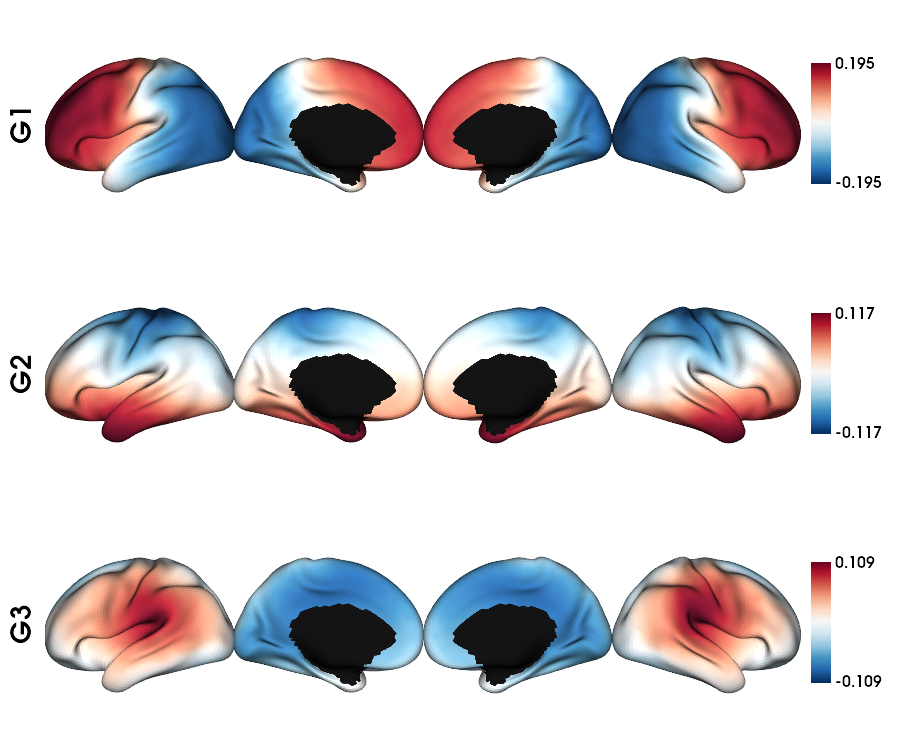

In [7]:
# Calculate the gradients
gd_dm, grad = fslr5k_dm_lr(gd_5k, mask_5k, Ngrad=Ngrad, log=False, S=0.85)

# plot the gradients
plot_hemispheres(f5k_lhi, f5k_rhi, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})


# Structural Connectome: single subject `fsLR-5k`

In [8]:
# List the file
sc_file = sorted(glob.glob(f"sub-{sub}/ses-{ses}/dwi/connectomes/*_surf-fsLR-5k_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii"))

# Loads the SC fsLR-5k matrix
sc_5k = load_sc(sc_file[0])


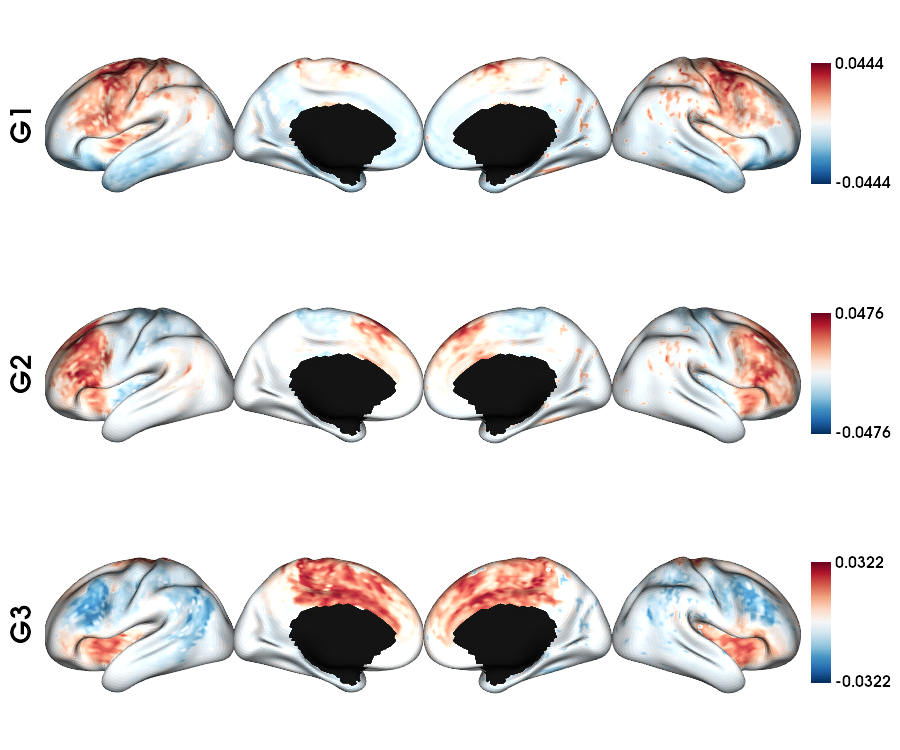

In [9]:
# Calculate the gradients
sc_dm, grad = fslr5k_dm_lr(sc_5k, mask_5k, Ngrad=Ngrad, log=False, S=0.9)

# PLot the gradients (G2-G4)
plot_hemispheres(f5k_lhi, f5k_rhi, array_name=grad[1:Nplot+1], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})


# Functional Connectome: single subject `fsLR-5k`

In [10]:
# List the file
func_acq='desc-se_task-rest_acq-AP_bold'
fc_file = sorted(glob.glob(f"sub-{sub}/ses-{ses}/func/{func_acq}/surf/*_surf-fsLR-5k_desc-FC.shape.gii"))

# Loads the FC fsLR-5k matrix
fc_5k = load_fc(fc_file[0])


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_30884/3332243303.py:35: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


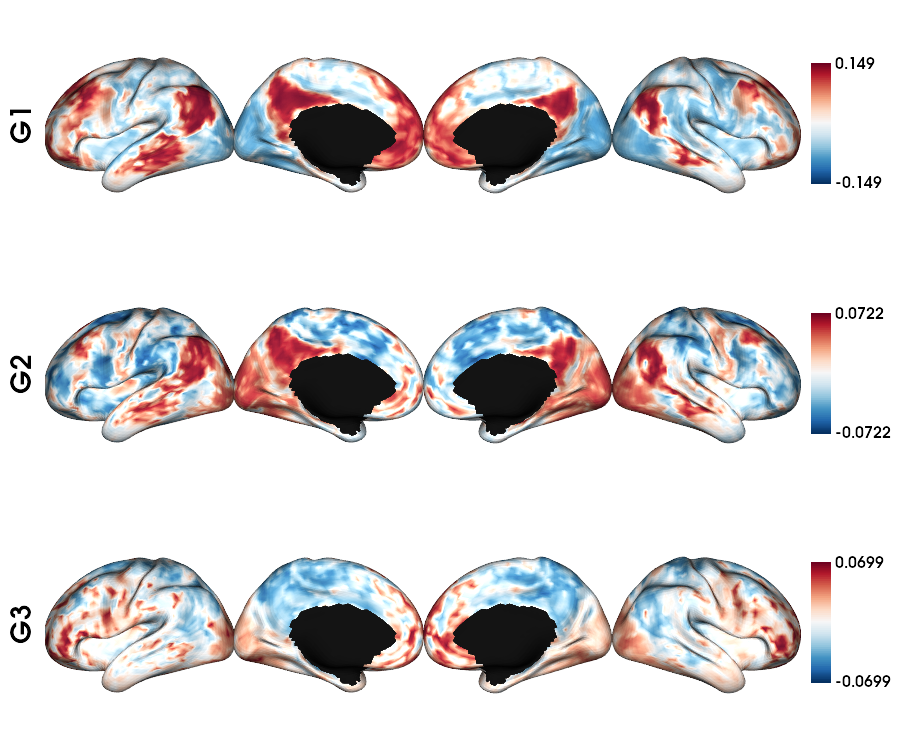

In [11]:
# Calculate the gradients
fc_dm, grad = fslr5k_dm(fc_5k, mask_5k, Ngrad=Ngrad, S=0.9)

# plot the gradients
plot_hemispheres(f5k_lhi, f5k_rhi, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})


# MPC T1map: single subject `fsLR-5k`

In [12]:
# MPC T1map acquisition and file
mpc_acq='T1map'
mpc_file = sorted(glob.glob(f"sub-{sub}/ses-{ses}/mpc/acq-{mpc_acq}/*surf-fsLR-5k_desc-MPC.shape.gii"))

# Loads the MPC fsLR-5k matrix
mpc_5k = load_mpc(mpc_file[0])


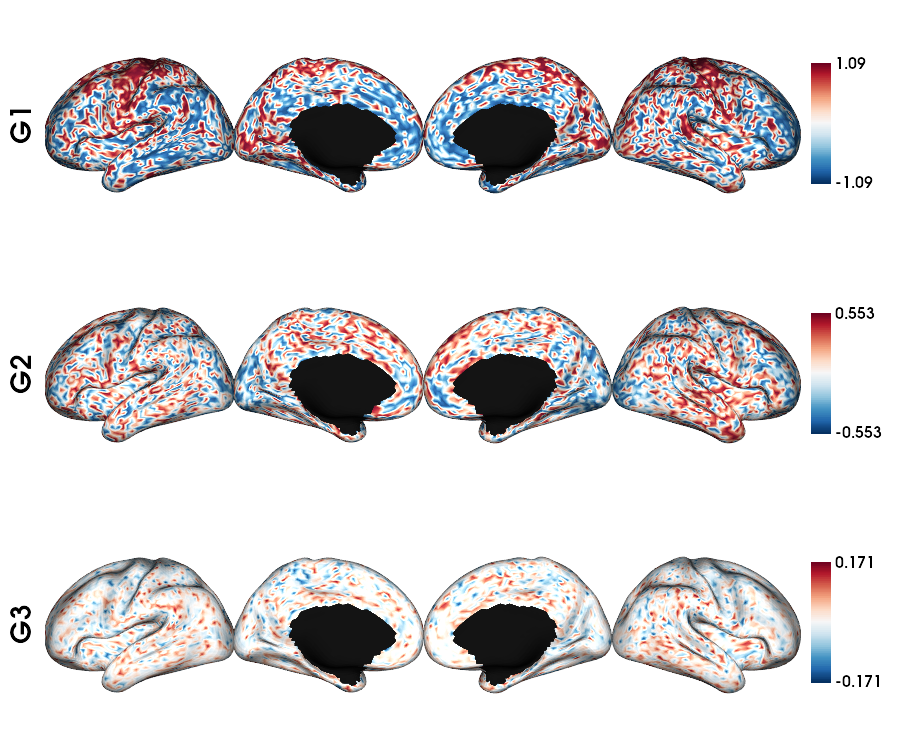

In [13]:
# Calculate the gradients (diffusion map)
mpc_dm, grad = fslr5k_dm(mpc_5k, mask_5k, Ngrad=Ngrad, S=0)

# Plot the gradients
plot_hemispheres(f5k_lhi, f5k_rhi, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})


# MPC T1map: ALL subjects `fsLR-5k`

### Load all matrices from a dataset processed

1. Start by generating a list of files using regular expressions for matrices with a consistent structure. Specifically, we'll focus on loading the `T1map MPC` connectome data for `fsLR-5k` from the MPC directory.

2. Create an empty three-dimensional array with dimensions `{ROI * ROI * vertices}`.

3. Load each matrix iteratively and populate the array with the data.

4. Once the array is populated, perform computations on it. In this case, we'll calculate the group mean connectome.

5. Use the group mean connectome to compute the group mean diffusion map for the `T1map MPC`.

6. Finally, visualize the results by plotting the first three gradients (eigen vectors) of the group mean diffusion map on a surface `fsLR-5k`.

In [14]:
# MPC T1map acquisition
mpc_acq='T1map'

# List all the matrices from all subjects
mpc_file = sorted(glob.glob(f"sub-PX*/ses-01/mpc/acq-{mpc_acq}/*surf-fsLR-5k_desc-MPC.shape.gii"))
N = len(mpc_file)
print(f"Number of subjects's MPC: {N}") 

# Loads all the MPC fsLR-5k matrices
mpc_5k_all=np.empty([N5k, N5k, len(mpc_file)], dtype=float)
for i, f in enumerate(mpc_file):
    mpc_5k_all[:,:,i] = load_mpc(f)

# Print the shape of the array: {vertices * vertices * subjects}
mpc_5k_all.shape


Number of subjects's MPC: 120


(9684, 9684, 120)

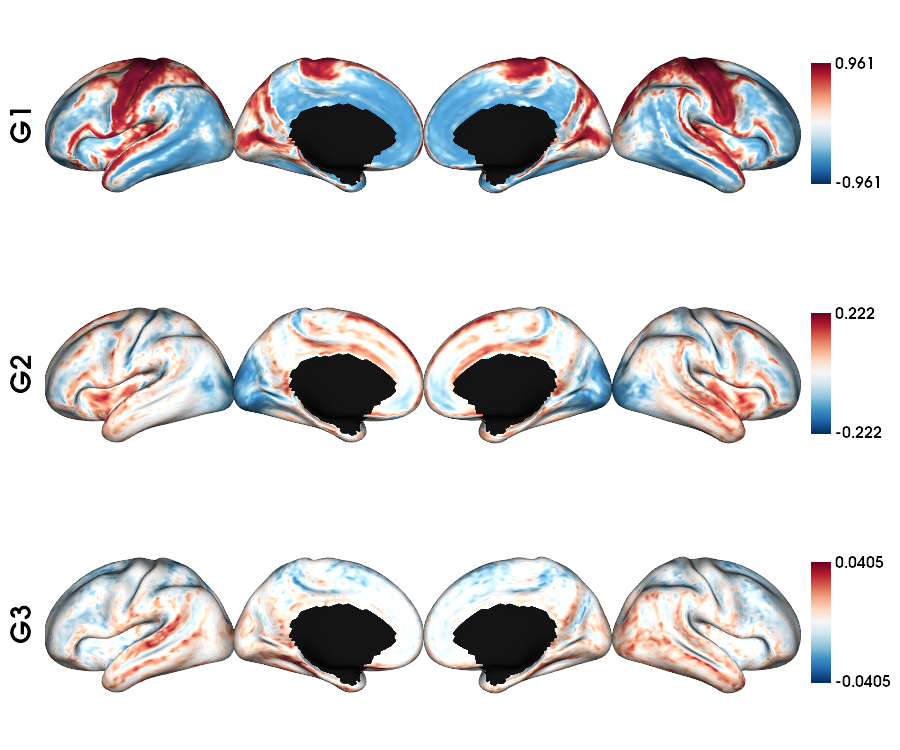

In [15]:
# Mean group MPC across all subjects (z-axis)
mpc_5k_mean = np.mean(mpc_5k_all, axis=2)

# Calculate the gradients (diffusion map)
mpc_dm, grad = fslr5k_dm(mpc_5k_mean, mask_5k, Ngrad=Ngrad, S=0)

# Plot the gradients
plot_hemispheres(f5k_lhi, f5k_rhi, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})
